In [1]:
import everest
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
# Download the data
star = everest.Everest(201367065, quiet = True)

In [27]:
# Remove outliers, get a nice subset of the data
cut = range(300,1700)
t = star.apply_mask(star.time)[cut]
F = star.apply_mask(star.fpix)[cut]
err = star.apply_mask(star.fraw_err)[cut]

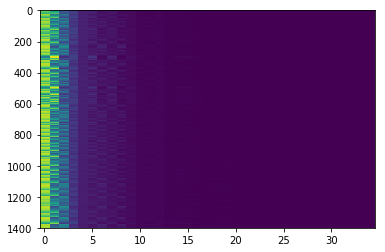

In [4]:
# 1st order design matrix, sorted by median flux
X = F / np.sum(F, axis = 1).reshape(-1,1)
inds = np.argsort(np.nanmedian(F, axis = 0))[::-1]
X = X[:,inds]
pl.imshow(X, aspect = 'auto');

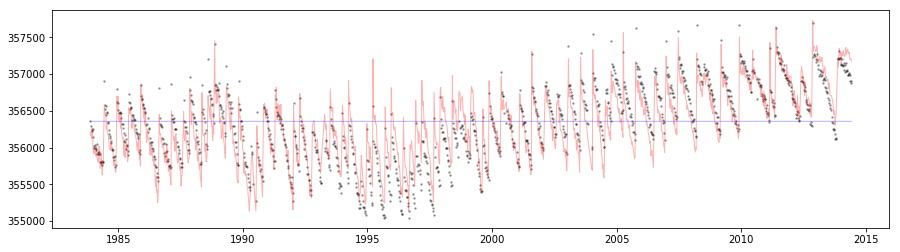

In [5]:
# De-trend with no GP, add a constant baseline term
A = np.concatenate((X, np.ones(X.shape[0]).reshape(-1,1)), axis = 1)
fsap = np.sum(F, axis = 1)
w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, fsap))
model = np.dot(A, w)

# Plot it. Black is raw data, red is full model, blue is constant baseline
fig = pl.figure(figsize = (15, 4))
pl.plot(t, fsap, 'k.', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, model, 'r-', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, np.dot(A[:,-1:], w[-1:]), 'b-', ms = 3, alpha = 0.3, lw = 1);

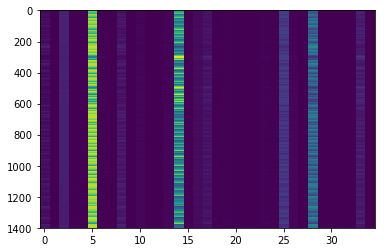

In [6]:
# Now scramble the indices in the design matrix
inds = np.arange(X.shape[1])
np.random.shuffle(inds)
Xnew = X[:,inds]
pl.imshow(Xnew, aspect = 'auto');

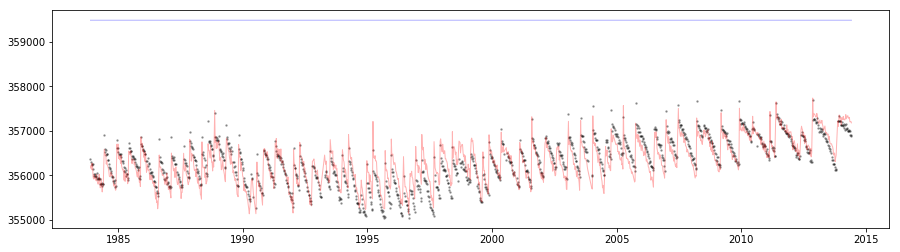

In [7]:
# De-trend with no GP, add a constant baseline term
Anew = np.concatenate((Xnew, np.ones(Xnew.shape[0]).reshape(-1,1)), axis = 1)
wnew = np.linalg.solve(np.dot(Anew.T, Anew), np.dot(Anew.T, fsap))
modelnew = np.dot(Anew, wnew)

# Plot it. Black is raw data, red is full model, blue is constant baseline
fig = pl.figure(figsize = (15, 4))
pl.plot(t, fsap, 'k.', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, modelnew, 'r-', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, np.dot(Anew[:,-1:], wnew[-1:]), 'b-', ms = 3, alpha = 0.3, lw = 1);

WTF?!

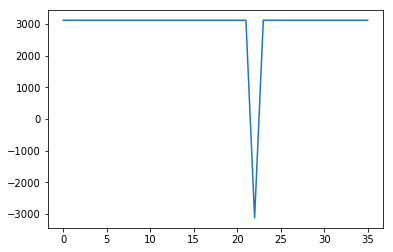

In [16]:
# Plot difference between weights in both cases.
pl.plot(w[np.argsort(w)] - wnew[np.argsort(wnew)]);

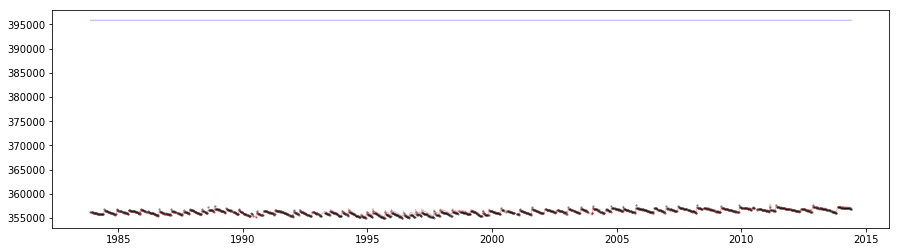

In [33]:
# OK, let's try with regularization.
A = np.concatenate((X, np.ones(X.shape[0]).reshape(-1,1)), axis = 1)
fsap = np.sum(F, axis = 1)
L = 1e6 * np.eye(A.shape[1])
L[-1,-1] = 1e10
C = np.nanmedian(err) * np.eye(X.shape[0])
ALAT = np.dot(np.dot(A, L), A.T)
LAT = np.dot(L, A.T)
w = np.dot(LAT, np.linalg.solve(C + ALAT, fsap))
model = np.dot(A, w)

# Plot it. Black is raw data, red is full model, blue is constant baseline
fig = pl.figure(figsize = (15, 4))
pl.plot(t, fsap, 'k.', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, model, 'r-', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, np.dot(A[:,-1:], w[-1:]), 'b-', ms = 3, alpha = 0.3, lw = 1);

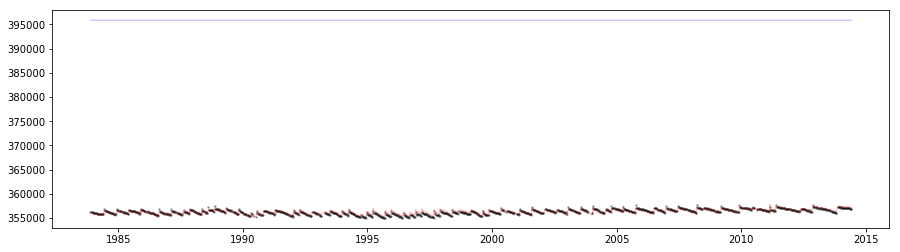

In [34]:
# OK, let's try with regularization.
Anew = np.concatenate((Xnew, np.ones(Xnew.shape[0]).reshape(-1,1)), axis = 1)
L = 1e6 * np.eye(Anew.shape[1])
L[-1,-1] = 1e10
C = np.nanmedian(err) * np.eye(Xnew.shape[0])
ALAT = np.dot(np.dot(Anew, L), Anew.T)
LAT = np.dot(L, Anew.T)
wnew = np.dot(LAT, np.linalg.solve(C + ALAT, fsap))
modelnew = np.dot(Anew, wnew)

# Plot it. Black is raw data, red is full model, blue is constant baseline
fig = pl.figure(figsize = (15, 4))
pl.plot(t, fsap, 'k.', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, modelnew, 'r-', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, np.dot(Anew[:,-1:], wnew[-1:]), 'b-', ms = 3, alpha = 0.3, lw = 1);

[  2.90734565e-02   6.39485585e-03   1.46808546e-01   2.46333204e-01
   1.87951688e-01   1.05482748e-01  -7.83636318e-01   5.20546603e-01
   7.24485047e-01  -2.81808019e-01   8.25142969e-01   2.21929364e+00
   3.43205936e-01   6.18126019e-01  -6.03129053e+00   4.92873953e+00
  -5.60442793e+00  -3.61161897e+00  -5.73618817e+00   2.34766239e+00
   5.53613796e+00   1.33091193e+00   2.78211104e+00   1.89159255e+01
  -1.63212408e+01   2.13752287e+00  -1.51169850e+00   7.56223244e+00
  -2.94017742e+00   4.41553493e+00   5.19961640e+00  -3.98177331e+00
  -6.89945338e+00   2.80343010e+00   2.25827681e+00   9.25597466e-01]


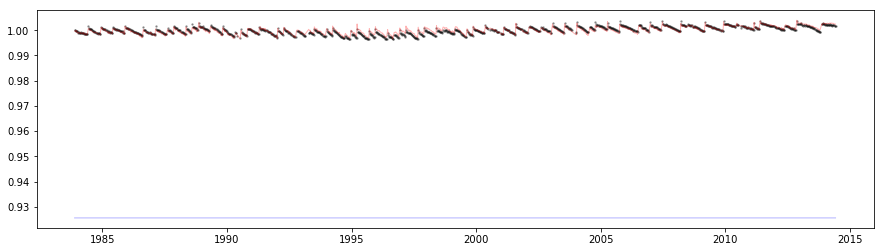

In [39]:
# Try better units.
fnorm = fsap / np.median(fsap)

# De-trend with no GP, add a constant baseline term
A = np.concatenate((X, np.ones(X.shape[0]).reshape(-1,1)), axis = 1)
w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, fnorm))
model = np.dot(A, w)

# Plot it. Black is raw data, red is full model, blue is constant baseline
fig = pl.figure(figsize = (15, 4))
pl.plot(t, fnorm, 'k.', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, model, 'r-', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, np.dot(A[:,-1:], w[-1:]), 'b-', ms = 3, alpha = 0.3, lw = 1);

print(w)

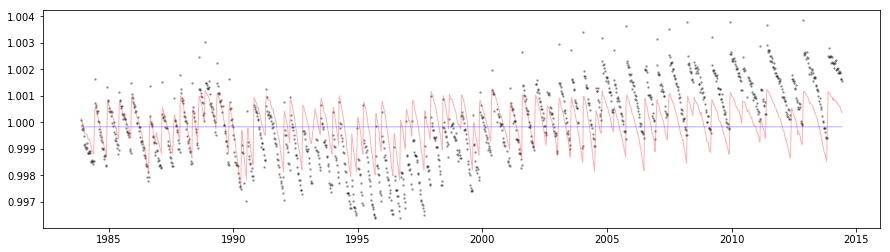

In [40]:
# OK, let's try with regularization.
Anew = np.concatenate((Xnew, np.ones(Xnew.shape[0]).reshape(-1,1)), axis = 1)
L = (1e6 / np.nanmedian(fsap) ** 2) * np.eye(Anew.shape[1])
L[-1,-1] = (1e10 / np.nanmedian(fsap) ** 2)
C = np.nanmedian(err) / np.nanmedian(fsap) * np.eye(Xnew.shape[0])
ALAT = np.dot(np.dot(Anew, L), Anew.T)
LAT = np.dot(L, Anew.T)
wnew = np.dot(LAT, np.linalg.solve(C + ALAT, fnorm))
modelnew = np.dot(Anew, wnew)

# Plot it. Black is raw data, red is full model, blue is constant baseline
fig = pl.figure(figsize = (15, 4))
pl.plot(t, fnorm, 'k.', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, modelnew, 'r-', ms = 3, alpha = 0.3, lw = 1);
pl.plot(t, np.dot(Anew[:,-1:], wnew[-1:]), 'b-', ms = 3, alpha = 0.3, lw = 1);

Beautiful.